In [1]:
# Environ
import scipy as scp
import tensorflow as tf
from scipy.stats import gamma
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import random
import multiprocessing as mp
import psutil
import pickle
import os
import re

# Own
import ddm_data_simulation as ds
import cddm_data_simulation as cds
import kde_training_utilities as kde_util
import kde_class as kde
import boundary_functions as bf

In [8]:
# DDM  
repeats = 1
my_means = np.zeros(repeats)
for i in range(repeats):
    out = cds.ddm_flexbound(v = 0, 
                            a = 0.96,
                            w = 0.5,
                            ndt = 0.5,
                            delta_t = 0.01, 
                            max_t = 20,
                            n_samples = 10000,
                            boundary_fun = bf.angle,
                            boundary_multiplicative = False, 
                            boundary_params = {"theta": 0.01})
    print(i)
    
    my_means[i] = np.mean(out[0][out[1] == 1])

0


In [7]:
- np.sin(0.1) / np.cos(0.1)

-0.10033467208545054

In [ ]:
# FULL DDM  
repeats = 50
my_means = np.zeros(repeats)
for i in range(repeats):
    out = cds.full_ddm(v = 0, 
                       a = 0.96,
                       w = 0.5,
                       ndt = 0.5,
                       dw = 0.0,
                       sdv = 0.0,
                       dndt = 0.5,
                       delta_t = 0.01, 
                       max_t = 20,
                       n_samples = 10000,
                       boundary_fun = bf.constant,
                       boundary_multiplicative = True, 
                       boundary_params = {})
    print(i)
    
    my_means[i] = np.mean(out[0][out[1] == 1])

In [ ]:
plt.hist(my_means, density = True)

In [ ]:
np.mean(out[0][out[1] == 1])

In [ ]:
plt.hist(out[0] * out[1], bins = 50)

In [ ]:
int(50 / out[2]['delta_t'] + 1)

In [ ]:
# LCA 
repeats = 1
my_means = np.zeros(repeats)
for i in range(repeats):
    out = cds.lca(v = np.array([0, 0], dtype = np.float32), 
                  a = 2, 
                  w = np.array([0.5, 0.5], dtype = np.float32), 
                  ndt = np.array([1.0, 1.0], dtype = np.float32),
                  g = -1.0,
                  b = 1.0,
                  delta_t = 0.01, 
                  max_t = 40,
                  n_samples = 10000,
                  boundary_fun = bf.constant,
                  boundary_multiplicative = True, 
                  boundary_params = {})
    print(i)
    my_means[i] = np.mean(out[0][out[1] == 1])

(array([1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 4.000e+00, 8.000e+00, 7.000e+00, 1.300e+01, 2.000e+01,
        2.600e+01, 3.400e+01, 7.000e+01, 1.060e+02, 1.720e+02, 2.410e+02,
        3.380e+02, 5.210e+02, 7.130e+02, 1.080e+03, 1.396e+03, 2.430e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 1.082e+03, 1.282e+03, 9.150e+02,
        5.560e+02, 3.980e+02, 2.470e+02, 1.750e+02, 1.150e+02, 8.400e+01,
        4.900e+01, 2.900e+01, 2.100e+01, 1.400e+01, 1.300e+01, 8.000e+00,
        3.000e+00, 6.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([-8.17008018, -7.84587704, -7.52167389, -7.19747074, -6.87326759,
        -6.54906445, -6.2248613 , -5.90065815, -5.576455  , -5.25225185,
        -4.92804871, -4.60384556, -4.27964241, -3.95543926, -3.63123611,
        -3.30703297, -2.98282982, -2.65862667, -2.33442352, -2.01022038,
        -1.68601723, -1.36181408, -1.03761093, -0.71340778, -0.38920464,
        -0.

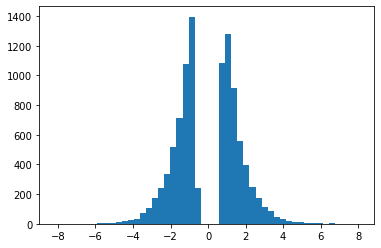

In [9]:
out[1][out[1] == 0] = -1
plt.hist(out[0] * out[1], bins = 50)

In [ ]:
# LCA 
repeats = 10
my_means = np.zeros(repeats)
for i in range(repeats):
    out = cds.ddm_flexbound(v = 0.0, 
                            a = 1.5, 
                            w = 0.5, 
                            ndt = 0.1,
                            delta_t = 0.01, 
                            max_t = 40,
                            n_samples = 10000,
                            boundary_fun = bf.constant,
                            boundary_multiplicative = True, 
                            boundary_params = {})
    print(i)
    my_means[i] = np.mean(out[0][out[1] == 1])

In [ ]:
plt.hist(my_means, density = True)

In [ ]:
out[1][out[1] == -1].shape

In [ ]:
int((40 / 0.01) + 1)

In [ ]:
my_bound = bf.constant

In [ ]:
my_bound

In [ ]:
my_bound(t = 100)

In [ ]:
h_Test = (1, 1, 1)

In [ ]:
h_Test + (1,2)

In [ ]:
h = ({'c': 1}, {'c2': 2})

In [ ]:
h_Test + h

In [ ]:
a = ({'c': 1},)

In [ ]:
h_Test + a

In [ ]:
def foo(name, *args, **kwargs):
    print ("args: ", args)
    print ("Type of args: ", type(args))
    if len(args)>2:
        args = args[0], args[1]     #- Created Same name variable.
    print ("Temp args:", args)

In [ ]:
foo('hello', ('a', 'b', 'c'))

In [ ]:
t = ('a', 'b', 'c')

In [ ]:
t[0]

In [ ]:
t2 = t[0], t[1]

In [ ]:
t2

In [ ]:
a = ['a']
a = a + ['b', 'c']

In [ ]:
a

In [ ]:
test_dat = pd.DataFrame(np.zeros((10, 5)), columns = ['v_0', 'v_1', 'a', 'b', 'c'])

In [ ]:
test_dat

In [ ]:
np.array(test_dat.loc[1, ['v_0', 'v_1']])

In [ ]:
my_keys = []
for key in test_dat.keys():
    if key[0] == 'v':
        my_keys.append(key)
np.array(test_dat.loc[1, ['v_0', 'v_1']])

In [ ]:
my_target_folder = '/media/data_cifs/afengler/tmp/'

In [ ]:
import make_data_lba as mdlba

In [ ]:
my_dat = mdlba.make_data_rt_choice(target_folder = my_target_folder)

In [ ]:
a = [1,2,3,4,5]

In [ ]:
a[:-2]

In [ ]:
np.isclose(0, 1e-15)

In [ ]:
1.0 - 1e-29 == 1.0

In [ ]:
np.max(my_dat['log_likelihood'])

In [ ]:
data = np.concatenate([out[0], out[1]], axis = 1)

In [ ]:
data[data[:,0] < 3, 0]

In [ ]:
np.log(1e-100)